<a href="https://colab.research.google.com/github/mgozon/DLG-UROP/blob/main/Batch_DLG_Evolution_Iris_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch-DLG Evolution - Iris Dataset
This notebook is based on the [Batch-DLG Iris Dataset](https://github.com/mgozon/DLG-UROP/blob/main/Batch_DLG_Iris_Dataset.ipynb), which implements the procedure in [Deep Leakage from Gradients](https://gist.github.com/Lyken17/91b81526a8245a028d4f85ccc9191884) on the Iris Dataset. In particular, a fully connected nueral network is trained using mini-batch gradients which are leaked.

# Setting up Libaries and Utilities

In [1]:
# setting up machine learning/visualization libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
#torch.manual_seed(100) # for generating the same random weights
from torch.utils.data import RandomSampler
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler

# setting up optimal device
print(torch.__version__)
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

1.13.1+cu116
Running on cpu


In [2]:
#@title Adding dlg_stats and dlg_models
from google.colab import drive
drive.mount('/content/drive/')
%run 'drive/MyDrive/UROP/Project Files/dlg_models.ipynb'
drive.flush_and_unmount()

Mounted at /content/drive/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
defined: assign_guess(guess, gt_dataset, n, verbose = False): guess_perm
defined: assign_best(guess, gt_dataset, n, verbose = False): best_match
defined: compute_stats(guess_perm, gt_data, recovered_threshold = 0.25): rel_errors, recovered_rate, cos_angles
defined: batch_DLG_Adam(net, criterion, device, original_dy_dx, batch_size, gt_data_len, gt_onehot_label_len, epoch_mult = 500, w_decay = 1e-12, scheduler_k = 0.001, verbose = False): dummy_data, losses
defined: label_to_onehot(target, n_classes): onehot_target
defined: train_net_Adam(net, criterion, device, train_data, train_target, output_dim, batch_size = 32, epochs = 100): losses
defined: test_net(net, test_data, test_target): prints accuracy
defined: train_net_Adam_DLG(net, criterion, device, scaler, train_data, train_target, output_dim, batch_size = 32, epochs = 100, verbo

# Preprocess Iris Dataset

In [3]:
# preprocess Iris Dataset for training
from sklearn.datasets import load_iris
dst = load_iris()
dst_length = dst.data.shape[0]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dst.data)

train_indices, test_indices = random_split(range(dst_length), [int(dst_length*4/5), int(dst_length*1/5)])
train_indices = train_indices.indices
test_indices = test_indices.indices
train_data = scaled_data[train_indices]; train_target = dst.target[train_indices]
test_data = scaled_data[test_indices]; test_target = dst.target[test_indices]

# require inputs/outputs to be 2D for uniformity
train_target = np.expand_dims(train_target, axis=1)
test_target = np.expand_dims(test_target, axis=1)

# reference variables for code
input_dim = 4
output_dim = 3

# Setting up Fully Connected Neural Network

In [4]:
# ***not equivalent to nn.CrossEntropyLoss(), which combines both nn.LogSoftmax() and nn.NLLLoss()
def cross_entropy_for_onehot(pred, onehot_target):
   return torch.mean(torch.sum(- onehot_target * torch.log(pred), 1))

In [5]:
# a fully connected neural network with random weights and biases
class FcNet(nn.Module):
    def __init__(self):
        super(FcNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Linear(input_dim, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, output_dim),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        out = self.body(x)
        return out

def weights_init(m):
    if hasattr(m, "weight"):
        nn.init.xavier_normal_(m.weight.data)
    if hasattr(m, "bias"):
        nn.init.normal_(m.bias.data)

# instantiation
net = FcNet().to(device)
net.apply(weights_init)
criterion = cross_entropy_for_onehot

# Train Model Normally

score: 28/30


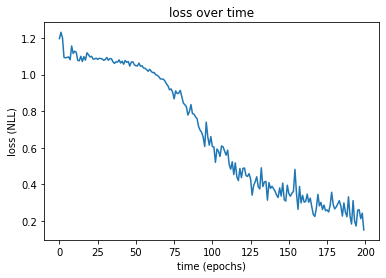

In [6]:
# note that parameters batch_size and epochs are tuned to yield a more accurate model
net.apply(weights_init)
batch_size = 32 # this affects the smoothness of the loss graph
epochs = 200
losses = train_net_Adam(net, criterion, device, train_data, train_target, output_dim, batch_size, epochs)
test_net(net, test_data, test_target)

plt.plot(list(range(epochs)), losses)
plt.title('loss over time')
plt.xlabel('time (epochs)')
plt.ylabel('loss (NLL)')
plt.show()

# Testing Single Batch DLG

In [7]:
# process specific batch gradient of flowers
def batch_grad(flower_indices):
    n = len(flower_indices)
    # flower_indices = torch.tensor(flower_indices)

    gt_data = torch.tensor(dst.data[flower_indices]).to(device)
    gt_label = torch.tensor(dst.target[flower_indices]).to(device); gt_label = torch.unsqueeze(gt_label, dim=1)
    gt_onehot_label = label_to_onehot(gt_label, n_classes=output_dim)

    out = net(gt_data.float())
    loss = criterion(out, gt_onehot_label)
    batch_dy_dx = torch.autograd.grad(loss, net.parameters())
    original_dy_dx = list((_.detach().clone() for _ in batch_dy_dx)) # share the gradients with other clients
    
    return original_dy_dx, gt_data, gt_label

[109, 70, 6, 2, 28, 42, 122, 23, 8, 3, 137, 35, 38, 21, 139, 43]


  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([7.2000, 3.6000, 6.1000, 2.5000], dtype=torch.float64) tensor([5.3359, 3.1551, 5.0663, 3.3782], grad_fn=<SelectBackward0>) RE (AE / TN):  0.22565735300434073
tensor([5.9000, 3.2000, 4.8000, 1.8000], dtype=torch.float64) tensor([4.5015, 2.9068, 4.7527, 2.3582], grad_fn=<SelectBackward0>) RE (AE / TN):  0.18172612614037514
tensor([4.6000, 3.4000, 1.4000, 0.3000], dtype=torch.float64) tensor([4.8542, 3.3936, 1.3398, 0.2990], grad_fn=<SelectBackward0>) RE (AE / TN):  0.04430953677438524
tensor([4.7000, 3.2000, 1.3000, 0.2000], dtype=torch.float64) tensor([4.8730, 3.2727, 1.3083, 0.2530], grad_fn=<SelectBackward0>) RE (AE / TN):  0.033444315901999616
tensor([5.2000, 3.4000, 1.4000, 0.2000], dtype=torch.float64) tensor([4.8790, 3.2701, 1.3026, 0.2522], grad_fn=<SelectBackward0>) RE (AE / TN):  0.057046414037931224
tensor([4.4000, 3.2000, 1.3000, 0.2000], dtype=torch.float64) tensor([4.8733, 3.2771, 1.3085, 0.2539], grad_fn=<SelectBackwar

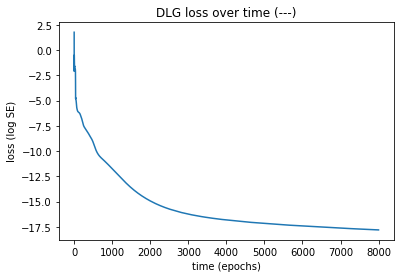

In [44]:
# testing batch-DLG with Adam
net.apply(weights_init) # see how much easier it is to attack
batch_size = 16
flower_indices = list(RandomSampler(range(dst.data.shape[0]), num_samples=batch_size))
print(flower_indices)
batch_dy_dx, gt_data, gt_label = batch_grad(flower_indices)

dummy_data, losses = batch_DLG_Adam(net, criterion, device, batch_dy_dx, batch_size, gt_data_len = 4, gt_onehot_label_len = 3, epoch_mult = 500, w_decay = 1e-12, scheduler_k = 0.01, verbose = False)
guess_perm = assign_guess(dummy_data, gt_data, batch_size, verbose = True)       # assign all
assign_best(dummy_data, gt_data, batch_size, verbose = True)                     # closest match

plt.plot(torch.log(torch.tensor(losses)))
plt.title('DLG loss over time (---)')
plt.xlabel('time (epochs)')
plt.ylabel('loss (log SE)')
plt.savefig('dlg8-.png', dpi=300)

# DLG Evolution

In [10]:
# results of training a model + dlg
net.apply(weights_init)
epochs = 500
batch_size = 16
dlg_rate = 25
verbose = True
losses, dlg_timestamps, AA_REs, AA_RRate, AA_cos_angles, CA_REs, CA_RRate, CA_cos_angles \
    = train_net_Adam_DLG(net, criterion, device, scaler, train_data, train_target, output_dim, batch_size, epochs, verbose, dlg_rate, \
                         gt_data_len = input_dim, gt_onehot_label_len = output_dim, epoch_mult=200, w_decay=1e-12, scheduler_k = 0.01)
test_net(net, test_data, test_target)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.4000, 2.9000, 4.3000, 1.3000], dtype=torch.float64) tensor([6.9359, 2.5757, 3.9539, 1.5325]) RE (AE / TN):  0.09022953640393798
tensor([5.6000, 2.7000, 4.2000, 1.3000], dtype=torch.float64) tensor([5.5923, 2.3102, 5.4995, 1.9435]) RE (AE / TN):  0.1972077816890009
tensor([6.8000, 2.8000, 4.8000, 1.4000], dtype=torch.float64) tensor([8.3797, 2.9065, 4.9036, 2.4047]) RE (AE / TN):  0.21118490141237586
tensor([6.3000, 2.5000, 5.0000, 1.9000], dtype=torch.float64) tensor([5.8592, 3.3450, 6.9006, 2.0426]) RE (AE / TN):  0.24680603934114279
tensor([5.6000, 3.0000, 4.5000, 1.5000], dtype=torch.float64) tensor([2.7504, 3.7016, 7.9028, 4.1646]) RE (AE / TN):  0.6589128059595692
tensor([5.0000, 3.2000, 1.2000, 0.2000], dtype=torch.float64) tensor([5.9120, 2.2999, 2.8333, 1.4998]) RE (AE / TN):  0.40418605966817645
tensor([7.7000, 3.0000, 6.1000, 2.3000], dtype=torch.float64) tensor([ 3.4836,  3.9526, 15.0743,  4.3415]) RE (AE / TN):  0.96

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.2000, 2.7000, 3.9000, 1.4000], dtype=torch.float64) tensor([5.6389, 2.5007, 3.6349, 1.9890]) RE (AE / TN):  0.11230509128150155
tensor([5.1000, 3.5000, 1.4000, 0.3000], dtype=torch.float64) tensor([5.7497, 2.8177, 0.5110, 0.1819]) RE (AE / TN):  0.20487460134002797
tensor([5.8000, 2.8000, 5.1000, 2.4000], dtype=torch.float64) tensor([6.1935, 2.1734, 3.5590, 2.1096]) RE (AE / TN):  0.202597376991361
tensor([4.6000, 3.4000, 1.4000, 0.3000], dtype=torch.float64) tensor([ 4.0867,  4.1548,  1.1262, -0.2507]) RE (AE / TN):  0.18665061289970172
tensor([5.8000, 2.7000, 5.1000, 1.9000], dtype=torch.float64) tensor([5.5772, 1.7913, 5.4318, 1.3282]) RE (AE / TN):  0.13639253946542956
tensor([6.8000, 2.8000, 4.8000, 1.4000], dtype=torch.float64) tensor([7.0318, 2.9909, 4.6115, 1.9862]) RE (AE / TN):  0.07703525409068909
tensor([6.3000, 3.3000, 4.7000, 1.6000], dtype=torch.float64) tensor([6.2951, 3.0875, 1.5985, 0.4486]) RE (AE / TN):  0.38

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.4000, 2.8000, 5.6000, 2.2000], dtype=torch.float64) tensor([6.4886, 2.3467, 5.1663, 2.5634]) RE (AE / TN):  0.07922734966445519
tensor([6.0000, 3.4000, 4.5000, 1.6000], dtype=torch.float64) tensor([6.7788, 3.6778, 3.4940, 0.7590]) RE (AE / TN):  0.18478892824160784
tensor([6.0000, 2.9000, 4.5000, 1.5000], dtype=torch.float64) tensor([6.7322, 2.3188, 4.0082, 2.3950]) RE (AE / TN):  0.1692547987842433
tensor([6.0000, 2.2000, 5.0000, 1.5000], dtype=torch.float64) tensor([5.7646, 2.3099, 6.8412, 0.4718]) RE (AE / TN):  0.2574961219332758
tensor([4.9000, 2.4000, 3.3000, 1.0000], dtype=torch.float64) tensor([6.0043, 2.9885, 3.0847, 0.5506]) RE (AE / TN):  0.20867882039396243
tensor([6.0000, 3.0000, 4.8000, 1.8000], dtype=torch.float64) tensor([4.1055, 3.0057, 5.6098, 1.6686]) RE (AE / TN):  0.24452640070330633
tensor([6.7000, 3.1000, 5.6000, 2.4000], dtype=torch.float64) tensor([7.1758, 2.5429, 7.3659, 1.8953]) RE (AE / TN):  0.206583

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.8000, 2.7000, 3.9000, 1.2000], dtype=torch.float64) tensor([6.8679, 2.8406, 4.2079, 1.1390]) RE (AE / TN):  0.14785031829324927
tensor([7.7000, 3.0000, 6.1000, 2.3000], dtype=torch.float64) tensor([ -3.6837,   6.5853, -18.5367,  -7.9292]) RE (AE / TN):  2.776453542285179
tensor([5.6000, 2.7000, 4.2000, 1.3000], dtype=torch.float64) tensor([4.8289, 2.1722, 5.1203, 1.9292]) RE (AE / TN):  0.19104144056833028
tensor([4.4000, 3.0000, 1.3000, 0.2000], dtype=torch.float64) tensor([ 2.1891,  3.3060, -3.9543, -2.4805]) RE (AE / TN):  1.1497247086503921
tensor([5.1000, 2.5000, 3.0000, 1.1000], dtype=torch.float64) tensor([5.8446, 1.9192, 2.8735, 1.7519]) RE (AE / TN):  0.17714138450544462
tensor([5.2000, 3.5000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 4.5998,  4.2294, -6.6277, -4.8960]) RE (AE / TN):  1.494915436236274
tensor([5.9000, 3.2000, 4.8000, 1.8000], dtype=torch.float64) tensor([5.6820, 2.9012, 5.3221, 1.8374]) RE (AE / T

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.7000, 3.8000, 1.7000, 0.3000], dtype=torch.float64) tensor([ 6.1758,  4.1989, -1.7708, -1.1149]) RE (AE / TN):  0.5377684586336332
tensor([6.2000, 2.2000, 4.5000, 1.5000], dtype=torch.float64) tensor([7.2579, 3.2751, 0.7895, 0.9147]) RE (AE / TN):  0.4990946010171292
tensor([5.4000, 3.4000, 1.7000, 0.2000], dtype=torch.float64) tensor([ 4.9091,  3.8009, -1.3824, -0.8893]) RE (AE / TN):  0.5040431525185579
tensor([5.8000, 2.7000, 5.1000, 1.9000], dtype=torch.float64) tensor([3.2581, 2.3836, 4.7228, 1.3302]) RE (AE / TN):  0.315626194279911
tensor([5.5000, 3.5000, 1.3000, 0.2000], dtype=torch.float64) tensor([ 4.4366,  3.9541, -2.4168, -0.0152]) RE (AE / TN):  0.5861864467294939
tensor([5.1000, 3.7000, 1.5000, 0.4000], dtype=torch.float64) tensor([ 4.5203,  4.6664, -0.7395,  0.1398]) RE (AE / TN):  0.3884168785254797
tensor([5.6000, 2.5000, 3.9000, 1.1000], dtype=torch.float64) tensor([ 4.0725,  3.9538,  2.2050, -1.6749]) RE (AE /

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.4000, 3.4000, 1.7000, 0.2000], dtype=torch.float64) tensor([ 4.8840,  3.7363, -1.1030, -0.3327]) RE (AE / TN):  0.4417974083464188
tensor([7.0000, 3.2000, 4.7000, 1.4000], dtype=torch.float64) tensor([8.0832, 2.5711, 5.1023, 1.6952]) RE (AE / TN):  0.14773884731118012
tensor([5.0000, 2.0000, 3.5000, 1.0000], dtype=torch.float64) tensor([5.9365, 2.6401, 2.7435, 1.3805]) RE (AE / TN):  0.21778664595301872
tensor([5.8000, 2.7000, 5.1000, 1.9000], dtype=torch.float64) tensor([6.1484, 3.0223, 6.2267, 3.0911]) RE (AE / TN):  0.20321842790832262
tensor([6.8000, 3.0000, 5.5000, 2.1000], dtype=torch.float64) tensor([5.2535, 2.8995, 8.9625, 2.3975]) RE (AE / TN):  0.40132210780533273
tensor([7.1000, 3.0000, 5.9000, 2.1000], dtype=torch.float64) tensor([6.1661, 1.5686, 9.1246, 2.7890]) RE (AE / TN):  0.37397284753684246
tensor([5.8000, 2.8000, 5.1000, 2.4000], dtype=torch.float64) tensor([5.0940, 2.8091, 6.1808, 3.4650]) RE (AE / TN):  0.1

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.9000, 3.6000, 1.4000, 0.1000], dtype=torch.float64) tensor([ 3.3294,  4.0755, -3.3607,  0.6658]) RE (AE / TN):  0.8120452759373011
tensor([7.7000, 3.8000, 6.7000, 2.2000], dtype=torch.float64) tensor([ 8.0697,  2.7257, 11.5019,  3.4750]) RE (AE / TN):  0.45868156181769754
tensor([5.1000, 3.8000, 1.6000, 0.2000], dtype=torch.float64) tensor([ 2.0141,  4.9611, -3.9553, -2.6615]) RE (AE / TN):  1.0768478955697383
tensor([6.5000, 2.8000, 4.6000, 1.5000], dtype=torch.float64) tensor([5.2076, 3.0131, 4.6643, 0.6318]) RE (AE / TN):  0.18345291982819703
tensor([4.4000, 3.0000, 1.3000, 0.2000], dtype=torch.float64) tensor([ 4.9160,  3.6381, -1.3326,  2.3201]) RE (AE / TN):  0.634100797650474
tensor([5.0000, 3.4000, 1.5000, 0.2000], dtype=torch.float64) tensor([5.6413, 3.4327, 1.4267, 0.4772]) RE (AE / TN):  0.11283054386487844
tensor([5.0000, 3.0000, 1.6000, 0.2000], dtype=torch.float64) tensor([ 4.9695,  3.3832,  4.6467, -0.4949]) RE (A

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.7000, 2.8000, 4.5000, 1.3000], dtype=torch.float64) tensor([6.5369, 2.0226, 5.7709, 2.8318]) RE (AE / TN):  0.2908100761260891
tensor([6.0000, 3.0000, 4.8000, 1.8000], dtype=torch.float64) tensor([7.2813, 1.2142, 9.2477, 2.9601]) RE (AE / TN):  0.6034693197961447
tensor([5.7000, 3.0000, 4.2000, 1.2000], dtype=torch.float64) tensor([4.7459, 3.9647, 4.6767, 2.6400]) RE (AE / TN):  0.2614959078471105
tensor([6.2000, 2.8000, 4.8000, 1.8000], dtype=torch.float64) tensor([7.9615, 2.2085, 7.1736, 3.1682]) RE (AE / TN):  0.38862598797269365
tensor([5.9000, 3.0000, 5.1000, 1.8000], dtype=torch.float64) tensor([6.8414, 2.0181, 9.4085, 3.3477]) RE (AE / TN):  0.5587474757477503
tensor([5.2000, 3.5000, 1.5000, 0.2000], dtype=torch.float64) tensor([5.2520, 3.0005, 3.1952, 1.6342]) RE (AE / TN):  0.3530510213251899
tensor([6.7000, 3.1000, 4.7000, 1.5000], dtype=torch.float64) tensor([9.1018, 1.3859, 6.6493, 1.6512]) RE (AE / TN):  0.398653869

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.6000, 2.8000, 4.9000, 2.0000], dtype=torch.float64) tensor([6.1762, 2.4640, 5.3705, 2.4136]) RE (AE / TN):  0.11161740491956189
tensor([6.0000, 3.4000, 4.5000, 1.6000], dtype=torch.float64) tensor([ 1.0682,  5.1831, -4.4578, -2.9886]) RE (AE / TN):  1.3528932883434825
tensor([4.8000, 3.4000, 1.9000, 0.2000], dtype=torch.float64) tensor([ 4.1073,  2.5195,  3.0619, -0.0759]) RE (AE / TN):  0.26475464746975313
tensor([6.7000, 3.3000, 5.7000, 2.1000], dtype=torch.float64) tensor([6.5386, 3.0945, 6.5037, 2.1579]) RE (AE / TN):  0.08799121273927046
tensor([5.2000, 3.5000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 2.6221,  6.3407, -4.1415, -1.7922]) RE (AE / TN):  1.1021723577488787
tensor([6.5000, 3.2000, 5.1000, 2.0000], dtype=torch.float64) tensor([ 2.6535,  5.1262, -7.4977, -0.9578]) RE (AE / TN):  1.5013408344684198
tensor([6.6000, 3.0000, 4.4000, 1.4000], dtype=torch.float64) tensor([ 3.5149,  4.3359, -5.2040, -2.2559]) RE (

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.4000, 3.2000, 4.5000, 1.5000], dtype=torch.float64) tensor([ 0.0824,  4.7954, -5.8524, -3.5441]) RE (AE / TN):  1.5412532834778039
tensor([6.6000, 3.0000, 4.4000, 1.4000], dtype=torch.float64) tensor([ 1.4931,  5.7552, -8.1138, -3.2015]) RE (AE / TN):  1.6917301022494717
tensor([5.6000, 2.8000, 4.9000, 2.0000], dtype=torch.float64) tensor([ 7.9299,  1.7708, 12.3419,  4.6121]) RE (AE / TN):  1.0109756069734226
tensor([6.5000, 3.2000, 5.1000, 2.0000], dtype=torch.float64) tensor([11.3006,  0.7386, 13.6646,  5.7104]) RE (AE / TN):  1.1869151741955335
tensor([5.4000, 3.9000, 1.3000, 0.4000], dtype=torch.float64) tensor([ 4.5822,  4.6851, -3.0537, -1.0534]) RE (AE / TN):  0.6954113729580982
tensor([6.2000, 2.9000, 4.3000, 1.3000], dtype=torch.float64) tensor([ 1.2724,  5.3791, -4.1002, -4.7294]) RE (AE / TN):  1.4314342449040711
tensor([5.0000, 3.5000, 1.3000, 0.3000], dtype=torch.float64) tensor([ 3.2673,  4.3331, -1.1097, -0.7837])

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.5000, 2.3000, 4.0000, 1.3000], dtype=torch.float64) tensor([-0.7821,  4.8748, -4.3537, -3.2528]) RE (AE / TN):  1.601988537122393
tensor([6.8000, 3.0000, 5.5000, 2.1000], dtype=torch.float64) tensor([ 9.6713,  0.5807, 14.6075,  6.2847]) RE (AE / TN):  1.128832090941393
tensor([6.0000, 3.4000, 4.5000, 1.6000], dtype=torch.float64) tensor([5.8331, 4.7612, 4.0695, 2.1455]) RE (AE / TN):  0.18327141486618684
tensor([5.4000, 3.4000, 1.7000, 0.2000], dtype=torch.float64) tensor([ 2.3017,  6.2966, -4.9097, -3.6411]) RE (AE / TN):  1.3232651300034848
tensor([6.3000, 3.3000, 6.0000, 2.5000], dtype=torch.float64) tensor([11.0445,  1.5398, 15.8757,  6.2414]) RE (AE / TN):  1.2154339951973432
tensor([6.2000, 2.2000, 4.5000, 1.5000], dtype=torch.float64) tensor([ 0.6123,  5.3759, -7.1813, -2.6630]) RE (AE / TN):  1.722162574430989
tensor([4.9000, 3.1000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 3.6370,  4.7565, -1.0806, -1.1528]) RE (A

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.4000, 3.2000, 5.3000, 2.3000], dtype=torch.float64) tensor([-0.7326,  6.4276, -6.4485, -3.2028]) RE (AE / TN):  1.6475985415023207
tensor([6.7000, 3.3000, 5.7000, 2.1000], dtype=torch.float64) tensor([8.0690e+00, 3.3740e-03, 1.7027e+01, 6.2159e+00]) RE (AE / TN):  1.3056204531133646
tensor([4.9000, 3.1000, 1.5000, 0.1000], dtype=torch.float64) tensor([ 1.7784,  4.7568, -2.8902, -1.8942]) RE (AE / TN):  0.99805363628254
tensor([6.7000, 3.1000, 4.4000, 1.4000], dtype=torch.float64) tensor([ 1.4244,  5.7536, -6.3277, -4.0776]) RE (AE / TN):  1.5406298136983125
tensor([6.3000, 2.3000, 4.4000, 1.3000], dtype=torch.float64) tensor([6.9646, 0.3135, 5.2928, 1.5329]) RE (AE / TN):  0.28168560049884356
tensor([6.5000, 3.0000, 5.2000, 2.0000], dtype=torch.float64) tensor([-1.3220,  5.2757, -6.5844, -4.1304]) RE (AE / TN):  1.7177735155977123
tensor([6.3000, 3.3000, 4.7000, 1.6000], dtype=torch.float64) tensor([ 0.6468,  5.2703, -7.1912, -4

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.6000, 3.0000, 4.4000, 1.4000], dtype=torch.float64) tensor([ 3.8661,  4.5373, -4.0138, -1.7343]) RE (AE / TN):  1.106497299813083
tensor([5.4000, 3.0000, 4.5000, 1.5000], dtype=torch.float64) tensor([ 1.1902,  5.2576, -0.6205, -3.6085]) RE (AE / TN):  1.1129367196586872
tensor([6.4000, 2.9000, 4.3000, 1.3000], dtype=torch.float64) tensor([ 3.1191,  4.5288, -2.4077, -3.7960]) RE (AE / TN):  1.1014627251787683
tensor([6.1000, 2.8000, 4.7000, 1.2000], dtype=torch.float64) tensor([ 0.9459,  5.6514, -3.3700, -4.1334]) RE (AE / TN):  1.3675878453125674
tensor([6.7000, 3.1000, 5.6000, 2.4000], dtype=torch.float64) tensor([ 2.3835,  5.2337, -7.4680, -2.0772]) RE (AE / TN):  1.5283182663642452
tensor([5.6000, 3.0000, 4.5000, 1.5000], dtype=torch.float64) tensor([ 1.8213,  4.8023, -3.3687, -0.0501]) RE (AE / TN):  1.1410687196922789
tensor([6.9000, 3.2000, 5.7000, 2.3000], dtype=torch.float64) tensor([ 2.8294,  5.8033, -6.9144, -2.3949]) 

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.5000, 2.3000, 4.0000, 1.3000], dtype=torch.float64) tensor([5.2500, 2.0497, 2.7487, 0.3962]) RE (AE / TN):  0.21704769525710602
tensor([6.2000, 2.9000, 4.3000, 1.3000], dtype=torch.float64) tensor([ 1.1807,  4.6114, -8.2590, -3.2804]) RE (AE / TN):  1.756602920072354
tensor([6.8000, 2.8000, 4.8000, 1.4000], dtype=torch.float64) tensor([10.6612,  0.3079, 14.0295,  5.3699]) RE (AE / TN):  1.242395909934134
tensor([5.6000, 3.0000, 4.5000, 1.5000], dtype=torch.float64) tensor([ 1.5096,  6.0320, -5.2878, -2.1788]) RE (AE / TN):  1.4668893112119563
tensor([5.6000, 2.7000, 4.2000, 1.3000], dtype=torch.float64) tensor([5.5280, 3.1190, 4.1939, 0.8744]) RE (AE / TN):  0.07900016613815629
tensor([5.6000, 2.5000, 3.9000, 1.1000], dtype=torch.float64) tensor([ 0.7453,  6.0006, -2.4965, -4.0147]) RE (AE / TN):  1.380010714449113
tensor([5.1000, 3.8000, 1.9000, 0.4000], dtype=torch.float64) tensor([ 2.7321,  4.1817, -4.7657,  0.4199]) RE (AE /

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.4000, 3.0000, 1.3000, 0.2000], dtype=torch.float64) tensor([ 4.7759,  3.2161, -0.3631, -0.3583]) RE (AE / TN):  0.3294289264374778
tensor([7.7000, 2.6000, 6.9000, 2.3000], dtype=torch.float64) tensor([ 9.5778,  0.2828, 16.3252,  6.2236]) RE (AE / TN):  0.975201103683826
tensor([5.0000, 3.2000, 1.2000, 0.2000], dtype=torch.float64) tensor([ 2.6585,  4.4740, -2.6450, -1.7066]) RE (AE / TN):  0.8337378181578109
tensor([6.0000, 2.2000, 5.0000, 1.5000], dtype=torch.float64) tensor([7.3432, 1.5006, 7.9152, 2.0212]) RE (AE / TN):  0.4030850572054345
tensor([5.1000, 3.3000, 1.7000, 0.5000], dtype=torch.float64) tensor([ 0.9166,  5.0638, -5.9922, -3.1399]) RE (AE / TN):  1.524283856605688
tensor([5.8000, 2.7000, 5.1000, 1.9000], dtype=torch.float64) tensor([ 1.3970,  5.5374, -8.6820, -3.4102]) RE (AE / TN):  1.8657187139078175
tensor([6.1000, 2.6000, 5.6000, 1.4000], dtype=torch.float64) tensor([7.0685, 1.8277, 9.1370, 3.1400]) RE (AE / 

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.4000, 3.2000, 1.3000, 0.2000], dtype=torch.float64) tensor([ 1.5078,  4.7824, -1.3475, -1.7260]) RE (AE / TN):  0.8300838963907431
tensor([6.3000, 2.8000, 5.1000, 1.5000], dtype=torch.float64) tensor([10.5802,  0.4134, 15.6941,  5.4654]) RE (AE / TN):  1.4160588789320812
tensor([4.6000, 3.4000, 1.4000, 0.3000], dtype=torch.float64) tensor([ 0.2986,  5.7259, -3.8393, -2.8407]) RE (AE / TN):  1.3269931024310642
tensor([6.3000, 2.7000, 4.9000, 1.8000], dtype=torch.float64) tensor([10.2205,  0.3905, 13.8780,  6.2840]) RE (AE / TN):  1.2789274845464556
tensor([6.7000, 3.1000, 4.4000, 1.4000], dtype=torch.float64) tensor([ -0.7741,   4.9769, -10.3778,  -2.8712]) RE (AE / TN):  1.9758822292629965
tensor([5.7000, 2.9000, 4.2000, 1.3000], dtype=torch.float64) tensor([ 0.8988,  6.0089, -6.5408, -2.9444]) RE (AE / TN):  1.660632317177637
tensor([4.8000, 3.0000, 1.4000, 0.3000], dtype=torch.float64) tensor([ 2.4392,  3.5251, -2.6161, -1.757

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.5000, 3.0000, 5.8000, 2.2000], dtype=torch.float64) tensor([10.3116,  0.3409, 16.6792,  7.4224]) RE (AE / TN):  1.3651721987844112
tensor([7.7000, 2.6000, 6.9000, 2.3000], dtype=torch.float64) tensor([10.8705,  0.9440, 17.5273,  6.5779]) RE (AE / TN):  1.1004013404002002
tensor([5.9000, 3.2000, 4.8000, 1.8000], dtype=torch.float64) tensor([  0.1614,   6.7555, -11.2501,  -5.7313]) RE (AE / TN):  2.246227120838624
tensor([4.9000, 3.6000, 1.4000, 0.1000], dtype=torch.float64) tensor([ 3.8075,  5.1142, -1.3789, -2.4093]) RE (AE / TN):  0.6704852180067731
tensor([5.0000, 3.4000, 1.6000, 0.4000], dtype=torch.float64) tensor([ 2.2477,  4.6026, -2.9534, -3.3635]) RE (AE / TN):  1.057399458138202
tensor([5.7000, 4.4000, 1.5000, 0.4000], dtype=torch.float64) tensor([ 3.6776,  4.6109, -5.6971, -2.4698]) RE (AE / TN):  1.0874780677666243
tensor([5.7000, 3.0000, 4.2000, 1.2000], dtype=torch.float64) tensor([ 0.7988,  5.3432, -4.1526, -2.7653

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.9000, 3.2000, 4.8000, 1.8000], dtype=torch.float64) tensor([6.4213, 1.7325, 9.5787, 4.1912]) RE (AE / TN):  0.6590221259677878
tensor([6.7000, 3.0000, 5.0000, 1.7000], dtype=torch.float64) tensor([11.6991,  0.9661, 14.1650,  6.0904]) RE (AE / TN):  1.2723928665759658
tensor([7.1000, 3.0000, 5.9000, 2.1000], dtype=torch.float64) tensor([10.8506,  0.4371, 16.0147,  5.8771]) RE (AE / TN):  1.179468080298592
tensor([5.7000, 3.8000, 1.7000, 0.3000], dtype=torch.float64) tensor([ 0.7109,  5.3617, -6.8660, -3.7955]) RE (AE / TN):  1.5342141156814002
tensor([5.1000, 3.5000, 1.4000, 0.3000], dtype=torch.float64) tensor([ 2.4207,  4.0680, -5.3354, -2.1660]) RE (AE / TN):  1.209283369552142
tensor([5.4000, 3.4000, 1.5000, 0.4000], dtype=torch.float64) tensor([ 1.6060,  6.1107, -7.1162, -2.1162]) RE (AE / TN):  1.5401900571505152
tensor([6.2000, 2.9000, 4.3000, 1.3000], dtype=torch.float64) tensor([ 1.6237,  4.9833, -8.2677, -3.9346]) RE (A

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.6000, 2.5000, 3.9000, 1.1000], dtype=torch.float64) tensor([5.7143, 2.8728, 3.4436, 1.0094]) RE (AE / TN):  0.08259273632629568
tensor([5.1000, 3.7000, 1.5000, 0.4000], dtype=torch.float64) tensor([ 5.0419,  4.3376, -2.0489, -0.5741]) RE (AE / TN):  0.5756428830629484
tensor([5.6000, 2.7000, 4.2000, 1.3000], dtype=torch.float64) tensor([ 7.6905,  3.3648,  2.6372, -0.0496]) RE (AE / TN):  0.3956534192708618
tensor([4.8000, 3.4000, 1.9000, 0.2000], dtype=torch.float64) tensor([ 5.4266,  4.2949,  0.0265, -1.7259]) RE (AE / TN):  0.46897437424233523
tensor([4.9000, 2.4000, 3.3000, 1.0000], dtype=torch.float64) tensor([ 2.0787,  4.6774, -2.7778, -1.6220]) RE (AE / TN):  1.1693019327927279
tensor([6.4000, 3.2000, 4.5000, 1.5000], dtype=torch.float64) tensor([ 3.5296,  5.2887, -5.3343, -2.9692]) RE (AE / TN):  1.3244886772185094
tensor([7.0000, 3.2000, 4.7000, 1.4000], dtype=torch.float64) tensor([ 1.4634,  5.8241, -8.4703, -2.6331]) R

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.7000, 3.3000, 5.7000, 2.1000], dtype=torch.float64) tensor([10.9358,  0.1046, 16.6548,  5.5734]) RE (AE / TN):  1.3148377062728944
tensor([5.0000, 3.4000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 1.1624,  5.3966, -3.9209, -3.2497]) RE (AE / TN):  1.2427419757301028
tensor([6.4000, 2.7000, 5.3000, 1.9000], dtype=torch.float64) tensor([ 0.1043,  5.3144, -6.7052, -3.0850]) RE (AE / TN):  1.641577032195961
tensor([6.6000, 3.0000, 4.4000, 1.4000], dtype=torch.float64) tensor([ 2.5495,  4.7161, -7.6449, -2.4189]) RE (AE / TN):  1.5566115552385027
tensor([5.3000, 3.7000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 1.7202,  5.3523, -5.9315, -3.6146]) RE (AE / TN):  1.3914329051766352
tensor([5.7000, 2.8000, 4.5000, 1.3000], dtype=torch.float64) tensor([2.9049, 2.1241, 6.3848, 2.5350]) RE (AE / TN):  0.4629698969367267
tensor([6.3000, 2.7000, 4.9000, 1.8000], dtype=torch.float64) tensor([6.5800, 3.0147, 5.1378, 1.6734]) RE (AE /

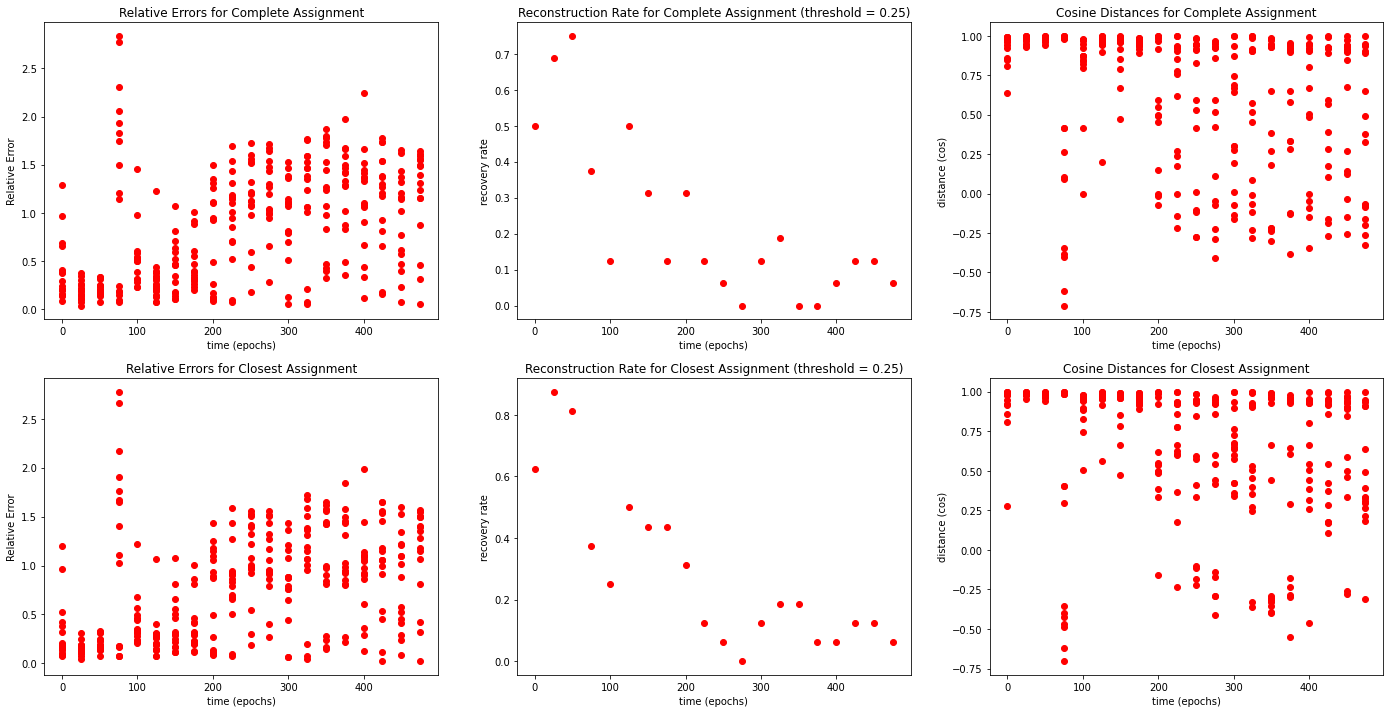

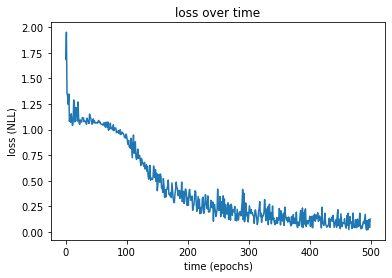

In [11]:
# create summary plots of MSE and normalized errors over time
fig, axs = plt.subplots(2, 3, figsize=(8*3, 6*2))

# complete assignment
axs[0, 0].plot(dlg_timestamps, AA_REs, 'ro')
axs[0, 0].set(title='Relative Errors for Complete Assignment', xlabel='time (epochs)', ylabel='Relative Error')

axs[0, 1].plot(dlg_timestamps, AA_RRate, 'ro')
axs[0, 1].set(title='Reconstruction Rate for Complete Assignment (threshold = 0.25)', xlabel='time (epochs)', ylabel='recovery rate')

axs[0, 2].plot(dlg_timestamps, AA_cos_angles, 'ro')
axs[0, 2].set(title='Cosine Distances for Complete Assignment', xlabel='time (epochs)', ylabel='distance (cos)')

# closest assignment
axs[1, 0].plot(dlg_timestamps, CA_REs, 'ro')
axs[1, 0].set(title='Relative Errors for Closest Assignment', xlabel='time (epochs)', ylabel='Relative Error')

axs[1, 1].plot(dlg_timestamps, CA_RRate, 'ro')
axs[1, 1].set(title='Reconstruction Rate for Closest Assignment (threshold = 0.25)', xlabel='time (epochs)', ylabel='recovery rate')

axs[1, 2].plot(dlg_timestamps, CA_cos_angles, 'ro')
axs[1, 2].set(title='Cosine Distances for Closest Assignment', xlabel='time (epochs)', ylabel='distance (cos)')

plt.savefig('train_DLG_16_nm.png', dpi=300)
plt.show()

plt.plot(list(range(epochs)), losses)
plt.title('loss over time')
plt.xlabel('time (epochs)')
plt.ylabel('loss (NLL)')
plt.savefig('train_DLG_16_nm_loss.png', dpi=300)
plt.show()

In [ ]:
#@title Evolution Plots (not updated)
# evolution of SEs, normalized errors, cosine distances
fig, axs = plt.subplots(len(dlg_timestamps), 3, sharex='col', figsize=(24, len(dlg_timestamps)*4))

for i in range(len(dlg_timestamps)):
    axs[i, 0].hist(torch.log(torch.tensor(dlg_SEs[i])), 50)
    axs[i, 0].set(title=f'log SE of batch DLG at epoch {dlg_timestamps[i]}', xlabel='log SE', ylabel='frequency')

    axs[i, 1].hist(torch.log(torch.tensor(dlg_n_errors[i])), 50)
    axs[i, 1].set(title=f'log NE of batch DLG at epoch {dlg_timestamps[i]}', xlabel='log NE', ylabel='frequency')

    axs[i, 2].hist(dlg_cos_angles[i], 50)
    axs[i, 2].set(title=f'cosine distances of batch DLG at epoch {dlg_timestamps[i]}', xlabel='cosine distance', ylabel='frequency')

# Notes

In [ ]:
# Todo


# future tasks -----------------------------------------------------------
# also add comments to functions abstracted out into a package
# look at dp
# look at papers more related to FL
# estimate how quickly the model can be trained + attacked
# icml workshop for results
# consider other medical dataset
# possible idea - PCA with image tasks to capture similarity between reconstructed and true input data
# consider dropout with a probability like ~ 0.20-0.25 (or even, aggressively, 0.5 - good for generalization)